
# Exercise session #3 - $k$-NN Classifier 

In this exercise you will implement  the **$k$-Nearest Neighbor classifier ($k$-NN)**. You will also get familiar with
other very important concepts related to machine learning in practice,
including data preprocessing, distance metrics, visualization, and model evaluation.

We have provided general functionality and pointers for you here. Please complete the code with your own implementation below. Please also discuss and answer the follow-up questions.

### 1. Dataset and problem description

The Healthy Body dataset contains body measurements acquired from **1250 people _from different ages, genders, and nationalities_** from different hospitals around the world. Health professionals have performed medical examinations and classified the individuals into three different body categories: **underweight, normal weight, and overweight.**

Our goal is to automate the role of the health professionals i.e, to predict the category of the new data . However, due to anonymity reasons, we have been provided access to limited information about the individuals: their measured _weights_ and _heights_, and their respective _body category_ only.

We will use these features to train a $k$-NN classifier for the task.

---

In [1]:
# Enable interactive plots, so you can zoom/pan/resize plots
%matplotlib inline

# Libraries for numerical handling and visualization
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(0)

## 2. Data loading and visualization

The goal of supervised classification algorithms such as $k$-NN is to use information from a set of labeled examples, i.e., examples for which we know their class assignments, to infer the classes for unlabeled examples.

In [2]:
# Weights, heights of individuals and their associated body category 
features_annotated_path = "./data/hbody_feats_annotated.npy"     
labels_annotated_path   = "./data/hbody_labels_annotated.npy"      

# Weights and heights of  individuals with unknown body category 
# Task: Figure out their body category label using k-NN classifier
features_unannotated_path = "./data/hbody_feats_unannotated.npy" 

# ground-truth body categories of  individuals with unknown body category  
# to evaluate the k-NN classifier
labels_unannotated_path = "./data/hbody_labels_unannotated_secret.npy"     

# Features organized in an NxD matrix: N examples and D features.
# Another way to look at it: each of the N examples is a D-dimensional feature vector.

data_train   = np.load(features_annotated_path)
data_test    = np.load(features_unannotated_path)
labels_train = np.load(labels_annotated_path)
labels_test  = np.load(labels_unannotated_path)

class_names = ('Underweight', 'Normal weight', 'Overweight')



**Q1. What are our labels? What are the features that we use to predict these labels?**

        weight, height
        
        training set



### 2.1 Data Summary

Number of examples in the training set  : 937
Number of examples in the test set      : 313


Text(0.5, 1.0, 'Histogram plot of each body category in the training set')

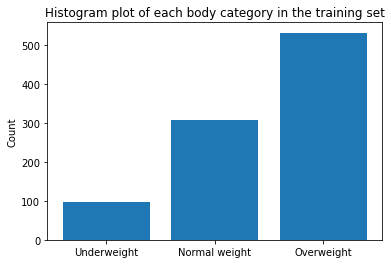

In [3]:
print("Number of examples in the training set  : {}".format(data_train.shape[0]))
print("Number of examples in the test set      : {}".format(data_test.shape[0]))

plt.bar(class_names, np.bincount(labels_train))
plt.ylabel('Count')
plt.title('Histogram plot of each body category in the training set')

### 2.2 Data visualization

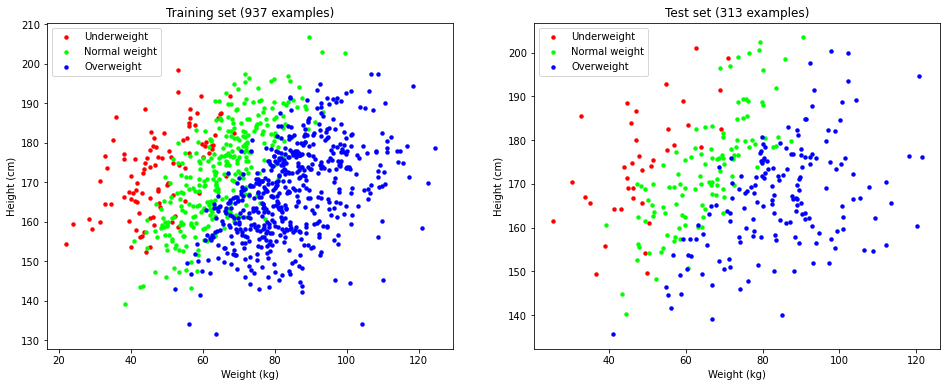

In [4]:
colors = np.array([[1.0, 0.0, 0], 
                   [0, 1.0, 0], 
                   [0.0, 0.0, 1]])

plt.figure(figsize=(16,6))

# visualize the training set
plt.subplot(1,2,1)
plt.title(f"Training set ({len(labels_train)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*data_train[labels_train==i].T,
                c=colors[i, None], alpha=1.0, 
                s=20, lw=0, label=class_name)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();

# visualize the test set
plt.subplot(1,2,2)
plt.title(f"Test set ({len(labels_test)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*data_test[labels_test==i].T,
                c=colors[i, None], alpha=1.0, 
                s=20, lw=0, label=class_name)
    
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();
plt.show()

**Q2. Do you think this is an easy or a difficult classification problem? Why?**  

        no, because there is not a lot of noise and the test not too


**Q3. What should the test set share in common with the training set?**  

    une distribution similaire



## 3. Normalizing the data

k-NN determines neighbors by computing the "distance" between two examples. For this process to work, we are required to normalize the features. This is true for many other machine learning algorithms as well.

A common way to normalize the data is by the so-called z-score standardization. It transforms values from an arbitrary range such that the results have mean $0$ and standard deviation $1$. 

The operation is defined as follows:

$$
x_{norm} = \frac {x - \mu_x} {\sigma_x},
$$

for _each feature x independently_  using its mean $\mu_x$ and standard deviation $\sigma_x$.

**Q4. What would happen if we don't do this?**  



In [5]:
def normalize(data, means, stds):
    """This function takes the data, the means,
    and the standard deviatons(precomputed). It 
    returns the normalized data.
    
    ///sum total, broadcasting
    
    Inputs:
        data : shape (NxD)
        means: shape (1XD)
        stds : shape (1xD)
        
    Outputs:
        data_normed: shape (NxD)
    """
    # WRITE YOUR CODE HERE
    # return the normalized features
    return (data - means)/stds

# test the  normalize function 
dummy_features = np.random.randint(100,size=(10,3))
means = dummy_features.mean(0,keepdims=True)
stds  = dummy_features.std(0,keepdims=True)
dummy_features_normed = normalize(dummy_features, means, stds)

if (np.allclose(dummy_features_normed.mean(axis=0), 0) and 
    np.allclose(dummy_features_normed.std(axis=0), 1)):
    print("Everything alright here!!")
else:
    print("Try again.")

Everything alright here!!


## 4. The $k$-Nearest Neighbors Classifier

The k-NN classifier assigns the most common label among its k-nearest neighbors for a given example. The method is very intuitive and can be summarized as:
- Compute the distance between the example to classify and all the training examples.
- Select the closest $k$ training examples.
- Assign to the example the most common label among those neighbors.

### 4.1 Distance metrics

There are many ways to define a distance between two examples. We introduce a very common distance metric, the Euclidean distance. 

#### Euclidean distance:

$$
D(\mathbf{v}, \mathbf{w}) = \sqrt{ \sum_{i=1}^D \left(\mathbf{v}^{(i)} - \mathbf{w}^{(i)}\right)^2 }
$$

This distance metric corresponds to our intuitive interpretation of the straight-line distance between two vectors $\mathbf{v}\in\mathbf{R}^D$ and $\mathbf{w}\in\mathbf{R}^D$. Note that $\mathbf{v}^{(i)}$ denotes the value in the dimension $i$ of $\mathbf{v}$.



In [6]:
def euclidean_dist(example, training_examples):
    """function to compute the Euclidean distance between a single example
    vector and all training_examples

    Inputs:
        example: shape (D,)
        training_examples: shape (NxD) 
    Outputs:
        return distance vector of length N
    """
    
    return np.sqrt(np.sum(pow(example-training_examples, 2), axis=1))



In [7]:
def find_k_nearest_neighbors(k, distances):
    """ Find the indices of the k smallest distances from a list of distances.
        Tip: use np.argsort()
    """
    
    # WRITE YOUR CODE HERE
    indices = np.argsort(distances)[:k]
    
    return indices

# test the find_k_nearest_neighbors function
dummy_distances = [10., 0.5, 200, 0.006, 43, 4.5, 11., 50]
top_k = 5
top_k_indices = find_k_nearest_neighbors(top_k,dummy_distances)

if np.allclose(top_k_indices,[3,1,5,0,6]):
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')
        

Implementation is correct


In [8]:
# Given a list of neighbor labels, choose the most frequent one.
# Tip: np.bincount and np.argmax are your friend.

def predict_label(neighbor_labels):
    """return the most frequent element in the input.
    """
    # WRITE YOUR CODE HERE

    return np.argmax(np.bincount(neighbor_labels))

# test label prediction
dummy_labels = [10, 3, 2, 10, 2, 2, 2, 10, 10, 11, 1, 2]

if predict_label(dummy_labels) == 2:
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')



Implementation is correct


### 4.2 $k$-NN classifier, step by step for a single test example

Let's implement the algorithm for **one data sample**.

**Q5.You are asked to use the training set's mean and std to normalize the data. Can you explain the reasoning behind this?** 

    pour pas avoir une donne qui a trop de poids vis a vis dune autre 



In [9]:
def choose_random_sample(data):
    """randomly chose a single datapoint from the given data matrix.
    Input:
        data: shape (NxD)
    Output:
        return a randomly chosen sample of length (D,)
    """
    
    total_samples = data.shape[0]
    sample =  data[np.random.choice(np.arange(total_samples),1)[0],:]
    return sample

In [10]:
# Use the functions you just defined to predict the label of a single example

# Choosing a random test example 
single_test_data =  choose_random_sample(data_test)



# IMPORTANT: Normalize the data. Use the mean and std of the training set.
# mean_val and std_val dimension should be (1x2)

# WRITE YOUR CODE HERE

mean_val = np.mean(data_train)
std_val = np.std(data_train)

# norm_train is the normalized data_train
norm_train = normalize(data_train, mean_val, std_val)

# norm_test_single is the normalized single_test_data
norm_test_single = normalize(single_test_data, mean_val, std_val)

# set the number of neighbors in the kNN classifier (hyperparameter)
k = 6

# find distance of the single test example w.r.t. all training examples
distances = euclidean_dist(norm_test_single, norm_train)

# find the nearest neighbors
nn_indices = find_k_nearest_neighbors(k, distances)

# find the labels of the nearest neighbors
neighbor_labels =  labels_train[nn_indices]

print("Nearest {} neighbors' labels: {}\n".format(k, ", ".join([class_names[x] for x in neighbor_labels])))

# find the best label
best_label = predict_label(neighbor_labels) 

print(f'Predicted label: {class_names[best_label]}')

Nearest 6 neighbors' labels: Overweight, Overweight, Overweight, Overweight, Overweight, Overweight

Predicted label: Overweight


##### The cell below is for visualization.

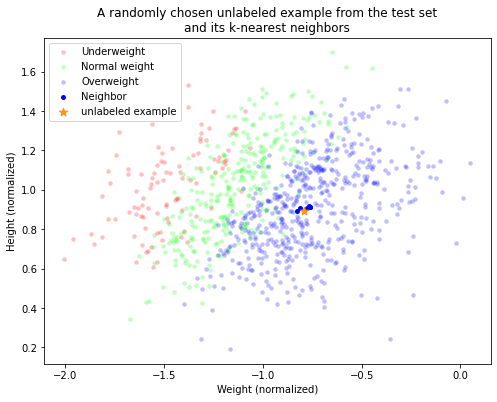

In [11]:
# Visualize the unknown point and its neighbors.
plt.figure(figsize=(8, 6))

plt.title(f"A randomly chosen unlabeled example from the "
          "test set\nand its k-nearest neighbors")

for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train[labels_train==i].T,
                c=colors[i, None], alpha=0.25, 
                s=20, lw=0, label=class_name)
    
for i, class_name in enumerate(class_names):
    class_indices = nn_indices[labels_train[nn_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_train[class_indices].T,
                    c=colors[i, None], alpha=1, 
                    s=25, lw=0, label='Neighbor')

# Make sure the norm_test is 1D vector.
plt.scatter(*norm_test_single.reshape((-1)), marker='*', c='darkorange', 
                 alpha=.9, s=75, label='unlabeled example')

plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

### 4.3 Performance metrics

To quantify the performance of our model, we want to obtain a score that tells us how close the predictions were to the expected classification.

The simplest way to do this is to compute the ratio of correctly predicted examples, also known as the accuracy:

$$
\frac 1 N \sum_{n=1}^N \mathbf{1}[\hat{y} = y]
$$

where the indicator function $\mathbf{1}[\hat{y} = y]$ returns 1 if the predicted $\hat{y}$ is equal to the ground-truth $y$ and returns 0 otherwise.

**Q6. Do you see any limitation to using accuracy to evaluate your model?**
    
    ce n'est pas precis...

    


**Q7. Can you think of other ways to evaluate your model?**

    no
    


**Q8. What other criteria, aside from accuracy, should one consider when choosing hyperparameters?**  





In [12]:
# Write a function that computes the accuracy between a predicted and the expected labels.
def compute_accuracy(predicted, target):
    """returns the accuracy score.
    """
    
    # WRITE YOUR CODE HERE
    return np.mean(predicted == target)

### 4.4 Putting things together to run the k-NN classifier for all examples

Let's implement the algorithm for **all data samples**.



In [13]:
# Write a function kNN_one_example that applies all the previous steps
# to predict the label of 'one' example.

def kNN_one_example(unlabeled_example, training_features, training_labels, k):
    """returns the label of single unlabelled_example.
    """
    
    # WRITE YOUR CODE HERE
    
    
    # Compute distances
    distances = euclidean_dist(unlabeled_example, training_features)
    
    # Find neighbors
    nn_indices = find_k_nearest_neighbors(k, distances)
    
    # Get neighbors' labels
    neighbor_labels = training_labels[nn_indices]
    
    # Pick the most common
    best_label = predict_label(neighbor_labels)
    
    return best_label

In [14]:
# Write a function kNN that applies 'kNN_one_example' function to an arbitrary number of examples.
# Tip: NumPy's apply_along_axis does most of the work for you. It's a one-liner!

def kNN(unlabeled, training_features, training_labels, k):
    """return the labels vector for all unlabeled datapoints.
    """
    
    # WRITE YOUR CODE HERE
    return np.apply_along_axis(func1d=kNN_one_example, axis=1, arr=unlabeled, 
                               training_features=training_features, 
                               training_labels=training_labels, k=k)

In [15]:
# Normalize your training data and  test data
# don't forget to normalize according to the mean and std of the training set

mean_val = np.mean(data_train)
std_val  = np.std(data_train)
norm_train_data = normalize(data_train, mean_val, std_val)
norm_test_data  = normalize(data_test, mean_val, std_val)

#choose a k value
k = 3

# run k-NN classifier on complete test data
predicted_labels_test = kNN(norm_test_data, norm_train_data, labels_train, k)

accuracy = compute_accuracy(predicted_labels_test, labels_test)
print("Test Accuracy is {:.1f}%".format(100*accuracy))


Test Accuracy is 82.4%


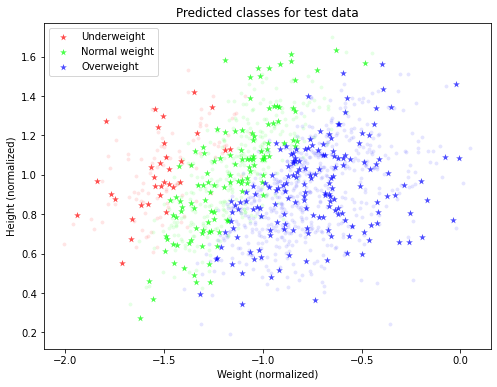

In [16]:

# Visualize the predictions on the unannotated test set
plt.figure(figsize=(8,6))
plt.title("Predicted classes for test data")

for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_data[labels_train==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
    
# represent test set by '*' marker
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_data[predicted_labels_test==i].T,
                c=colors[i, None], marker='*', alpha=0.7, 
                s=50, lw=0, label=class_name)
    
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

## 5 Cross Validation

How should we be choosing the value of k? If we choose the k that gives us the highest **test** accuracy, we would be **cheating**, because we would be tuning our model to its test performance. 

In practice, we choose the k that gives us the highest **validation** accuracy, via the cross-validation method. By doing so, we ensure that we select a method which generalizes well to unseen test data.

### 5.1.  K-Fold Cross Validation 

K-fold is a type of cross validation technique. It works in the following way:

1 - Select a $k$ (do not confuse this with the K-Fold of the cross validation, this is the $k$ for the kNN method).

2 - Split the training data in K parts and select 1 part as our validation set and the rest as our training set.

3 - Train our model on our training set and find the accuracy of the validation set. 

4 - Repeat steps 2 and 3  K times, each time selecting a different part of the data for the validation set. In the end we will find K different validation accuracies. We will average the validation accuracies and find the validation accuracy that corresponds to the k we chose for kNN. (See the image below).

5 - Repeat steps 1-4 (the whole process) for different $k$ values (hyperparameter for kNN). 

6 - Find the $k$ value that gave the highest validation accuracy. Train your model on the whole training set using this $k$. Test on the test set and report the test accuracy.



**Q8. What is the difference between validation set and test set?**  

    Validation test is in the training set



![](cross_validation.png)



### 5.2. Implementation

Now let's begin! We will be doing steps 1-4 of our algorithm above. We will do a K-Fold cross validation to find the validation accuracy for a selected $k$.

In [32]:
def KFold_cross_validation_KNN(X, Y, K, k):
    '''
    K-Fold Cross validation function for K-NN
    Inputs:
        X : training data
        Y: training labels
        K: number of folds (K in K-fold)
        k: number of neighbors for kNN algorithm (the hyperparameter)
        
    Returns:
        Average validation accuracy for the selected k.
    '''
    
    running_acc = 0
    for fold_ind in range(K):
        #Split the data into training and validation folds:
        
        #all the indices of the training dataset
        all_ind = np.arange(X.shape[0])
        split_size = X.shape[0]//K
        
        val_ind = all_ind[fold_ind*split_size:(fold_ind+1)*split_size]
        ## YOUR CODE HERE (hint np.setdiff1d is your friend)
        train_ind = np.setdiff1d(all_ind, val_ind)
        
        X_train_fold = X[train_ind,:]
        Y_train_fold = Y[train_ind]
        X_val_fold = X[val_ind,:]
        Y_val_fold = Y[val_ind]

        # Run KNN using the data folds you found above.
        #YOUR CODE HERE
        Y_val_fold_pred = kNN(X_val_fold, X_train_fold, Y_train_fold, k)
        #Calculate the accuracy
        running_acc += compute_accuracy(Y_val_fold_pred, Y_val_fold)
    
    #Find the average validation accuracy over K:
    ave_acc = running_acc/K
    return ave_acc

In [33]:
# Perform a 4-fold cross validation using k-NN, with k=5.

K = 4 # 4 fold cross validation
k = 5 # number of nearest neighbours for k-NN
acc = KFold_cross_validation_KNN(norm_train_data, labels_train, K, k)
print(f"{k}-NN Classifier predicted with average validation accuracy of {acc:.2%}.")

# If your accuracy is not above 80%, you may have made a mistake.

5-NN Classifier predicted with average validation accuracy of 86.00%.


### 5.3 Hyperparameter optimization

Now let's find the best $k$! Run the function you wrote above for different values of $k$.

We can evaluate our model under different values of $k$ to compare them. A simple way to do it is to evaluate our model's predictions for the same validation set when using different values of $k$.


In [34]:
# Call the cross validation method with different k values

def run_cv_for_hyperparam(X, Y, K, k_list):
    '''
    K-Fold Cross validation function for K-NN
    Inputs:
        X : training data
        Y: training labels
        K: number of folds (K in K-fold)
        k: a list of k values for kNN 
        
    Returns:
        model_performance:  A list of validation accuracies corresponding to the k-values.
                        
    '''
    
    model_performance = [] 
    for k in k_list:
        #YOUR CODE HERE
        model_performance.append(KFold_cross_validation_KNN(X, Y, K, k))    
    return model_performance


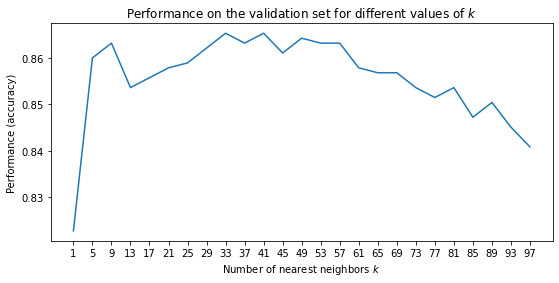

In [35]:
# Visualize the performances for different values of k

# Try these values for hyperparameter k
k_list = range(1, 100, 4)          
K = 4 # K-Fold
## YOUR CODE HERE
model_performance= run_cv_for_hyperparam(norm_train_data,labels_train, K, k_list)

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_list, model_performance)
plt.xlabel("Number of nearest neighbors $k$")
plt.xticks(k_list)
plt.ylabel("Performance (accuracy)");

In [36]:
# Pick hyperparameter value that yields the best performance
# WRITE YOUR CODE HERE
best_k = k_list[np.argmax(np.array(model_performance))]

print(f"Best number of nearest neighbors on validation set is k={best_k}")

Best number of nearest neighbors on validation set is k=33


### 5.4. Test accuracies for best model.

Now that we have tuned our model, we can apply it for prediction on the test set using the optimal $k$ found on cross-validations set.

**Q. How do you expect the model to perform, compared with the cross-validation set performance?**

**A.** If our validation set at every fold level is representative of the underlying distribution, we can expect accurate predictions. How accurate they are will depend on the problem. Usually due to sampling bias in the training and validation sets, we can expect slightly lower results on the test set.

In [37]:
# Get predicted labeles for unannotated data.
# WRITE YOUR CODE HERE
predicted_labels_test = kNN(norm_test_data, norm_train_data, labels_train, best_k)
accuracy = compute_accuracy(predicted_labels_test, labels_test)
print("Test Accuracy is {:.1f}%".format(100*accuracy))

Test Accuracy is 86.3%


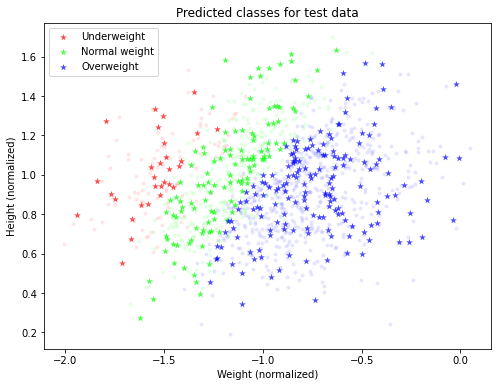

In [38]:

# Visualize the predictions on the unannotated test set
plt.figure(figsize=(8,6))
plt.title("Predicted classes for test data")

for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_data[labels_train==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
    
# represent test set by '*' marker
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_data[predicted_labels_test==i].T,
                c=colors[i, None], marker='*', alpha=0.7, 
                s=50, lw=0, label=class_name)
    
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();